In [1]:
import pandas as pd
from src.train import *
from src.model import CNNLSTMModel
from src.dataset import *
from src.preprocess import *
from src.visualize import *
import torch

## Hyper-Parameter

In [2]:
performe_visualization = False

In [3]:
# some important parameters
pre_day = 5

feature_cols = [
    "metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED",  # ambient temperature
    "metric.STATUS_INTERNAL_TEMP.MEASURED",          # internal temperature
    "metric.AC_VOLTAGE_AB.MEASURED",                 # AC voltage
    "metric.AC_VOLTAGE_BC.MEASURED",                 # AC voltage
    "metric.AC_VOLTAGE_CA.MEASURED",                 # AC voltage
    "metric.DC_VOLTAGE.MEASURED",                  # DC voltage
    "metric.AC_POWER.MEASURED",                     # AC power
]

exclude_periods = [
    [pd.Timestamp('2021-01-01'), pd.Timestamp('2021-12-23')], # data collection issue
    [pd.Timestamp('2023-02-23'), pd.Timestamp('2023-08-26')], # anomalies in the data
]

## Data Preprocessing
### Load Data

In [4]:
inverter_data = load_parquet_data('data/inverter_data')
failure_sessions = load_failure_sessions('data/failure_sessions_w_maintenance.csv', min_days=3)

Loaded 15 parquet files → 6126272 rows
Kept 61 sessions longer than 3 days


In [5]:
visualize_failure_timeline(failure_sessions)

In [6]:
if performe_visualization:
    # Visualize the raw data
    visualize_mean_values(inverter_data, failure_sessions, feature_cols, 'visualization', 'raw_data')

In [7]:
# remove unused columns
filtered_data = inverter_data[['event_local_time', 'device_name'] + feature_cols].copy()

### Anomoly Detection

In [8]:
if "metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED" in filtered_data.columns:
    anomaly_ids = filtered_data["metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED"]>=100
    filtered_data.loc[anomaly_ids, "metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED"] = None
    print("Anomalies in STATUS_AC_MOD_ADMISSION_TEMP removed:", anomaly_ids.sum())

Anomalies in STATUS_AC_MOD_ADMISSION_TEMP removed: 244163


### Missing Value Imputation

In [9]:
imputed_df = missing_value_imputation(
    filtered_data, feature_cols, 
    time_col='event_local_time', 
    device_col='device_name', 
    short_gap_limit=0, 
    long_fill_value=0.0, 
    add_missing_mask=True
    )
extended_feature_cols = feature_cols+[col+'_missing' for col in feature_cols]

### Downsampling

In [10]:
downsampled_data = downsample_inverter_raw(imputed_df, drop_empty_bins=False)
downsampled_data.dropna(inplace=True) # NaN will be generated by downsampling, so we drop them

Downsampling 6126272 rows using following method: 
                                               Column Aggregation
0                       metric.AC_VOLTAGE_AB.MEASURED        mean
1                       metric.AC_VOLTAGE_BC.MEASURED        mean
2                       metric.AC_VOLTAGE_CA.MEASURED        mean
3                          metric.DC_VOLTAGE.MEASURED        mean
4                            metric.AC_POWER.MEASURED        mean
5               metric.AC_VOLTAGE_AB.MEASURED_missing        mean
6               metric.AC_VOLTAGE_BC.MEASURED_missing        mean
7               metric.AC_VOLTAGE_CA.MEASURED_missing        mean
8                  metric.DC_VOLTAGE.MEASURED_missing        mean
9                    metric.AC_POWER.MEASURED_missing        mean
10       metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED         max
11               metric.STATUS_INTERNAL_TEMP.MEASURED         max
12  metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED_m...        mean
13       metric.STATUS_IN

In [11]:
if performe_visualization:
    # Visualize the downsampled data
    visualize_mean_values(
        downsampled_data, 
        failure_sessions, 
        extended_feature_cols, 
        'visualization', 
        'downsampled_data',
        freq=None
    )

### Data Cleaning

In [12]:
print("failure_sessions shape:", failure_sessions.shape)
failure_sessions['event_local_time'] = failure_sessions['start_time']
filtered_sessions = exclude_periods_from_data(failure_sessions, exclude_periods)
filtered_sessions['event_local_time'] = filtered_sessions['end_time']
filtered_sessions = exclude_periods_from_data(filtered_sessions, exclude_periods)
print("failure_sessions shape:", filtered_sessions .shape)

failure_sessions shape: (61, 6)
Excluded 2 periods, remaining data size: 47
Excluded 2 periods, remaining data size: 47
failure_sessions shape: (47, 7)


In [13]:
visualize_failure_timeline(filtered_sessions)

In [14]:
print("inverter_data shape:", downsampled_data.shape)
downsampled_data = exclude_periods_from_data(downsampled_data, exclude_periods)
print("Excluded data shape:", downsampled_data.shape)

inverter_data shape: (1021056, 16)
Excluded 2 periods, remaining data size: 862112
Excluded data shape: (862112, 16)


### Data Labeling

In [15]:
downsampled_data = prepare_dataset(downsampled_data, failure_sessions, pre_days=pre_day)

Total pre-failure rows: 6064
Total rows: 837811


### Feature Engineering

In [16]:
# month_of_year 範圍 1~12
downsampled_data['month_sin'] = np.sin(2 * np.pi * downsampled_data['event_local_time'].dt.month / 12)
downsampled_data['month_cos'] = np.cos(2 * np.pi * downsampled_data['event_local_time'].dt.month / 12)

# 如果還有 hour_of_day (0~23) 也可以同理轉
downsampled_data['hour_sin'] = np.sin(2 * np.pi * downsampled_data['event_local_time'].dt.hour / 24)
downsampled_data['hour_cos'] = np.cos(2 * np.pi * downsampled_data['event_local_time'].dt.hour / 24)

extended_feature_cols += ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']

In [17]:
if performe_visualization:
    visualize_mean_values(downsampled_data, failure_sessions, extended_feature_cols+['label'], 
                                title='processed_data', freq=None)

### Split Dataset

In [18]:
split_time = [pd.Timestamp('2024-06-30'), pd.Timestamp('2025-01-01')]


train_df = downsampled_data[downsampled_data['event_local_time'] <= split_time[0]].copy()
val_df = downsampled_data[(downsampled_data['event_local_time'] > split_time[0]) & (downsampled_data['event_local_time'] <= split_time[1])].copy()
test_df = downsampled_data[downsampled_data['event_local_time'] > split_time[1]].copy()

In [19]:
print('train set period:', train_df['event_local_time'].min(), train_df['event_local_time'].max())
print('validation set period:', val_df['event_local_time'].min(), val_df['event_local_time'].max())
print('test set period:', test_df['event_local_time'].min(), test_df['event_local_time'].max())

train set period: 2021-12-24 00:00:00 2024-06-30 00:00:00
validation set period: 2024-06-30 00:30:00 2025-01-01 00:00:00
test set period: 2025-01-01 00:30:00 2025-07-23 23:30:00


In [20]:
extended_feature_cols

['metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED',
 'metric.STATUS_INTERNAL_TEMP.MEASURED',
 'metric.AC_VOLTAGE_AB.MEASURED',
 'metric.AC_VOLTAGE_BC.MEASURED',
 'metric.AC_VOLTAGE_CA.MEASURED',
 'metric.DC_VOLTAGE.MEASURED',
 'metric.AC_POWER.MEASURED',
 'metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED_missing',
 'metric.STATUS_INTERNAL_TEMP.MEASURED_missing',
 'metric.AC_VOLTAGE_AB.MEASURED_missing',
 'metric.AC_VOLTAGE_BC.MEASURED_missing',
 'metric.AC_VOLTAGE_CA.MEASURED_missing',
 'metric.DC_VOLTAGE.MEASURED_missing',
 'metric.AC_POWER.MEASURED_missing',
 'hour_sin',
 'hour_cos',
 'month_sin',
 'month_cos']

### Standardization

In [21]:
from sklearn.preprocessing import StandardScaler
feature_to_standardize = feature_cols
scaler = StandardScaler()
train_df[feature_to_standardize] = scaler.fit_transform(train_df[feature_to_standardize])
val_df[feature_to_standardize] = scaler.transform(val_df[feature_to_standardize])
test_df[feature_to_standardize] = scaler.transform(test_df[feature_to_standardize])

In [22]:
if performe_visualization:
    visualize_mean_values(train_df, failure_sessions, extended_feature_cols+['label'], 
                                 'visualization', 'train_data', freq=None)
    visualize_mean_values(val_df, failure_sessions, extended_feature_cols+['label'], 
                                 'visualization', 'val_data', freq=None)
    visualize_mean_values(test_df, failure_sessions, extended_feature_cols+['label'],
                                    'visualization', 'test_data', freq=None)

### Create Dataset/Data Loader

In [23]:
from torch.utils.data import DataLoader
window_size = 2*24*7 # 30 minutes*2*24*7 = 7 days
normal_stride = 2*6 # 30 minutes*2*6 = 6 hours
positive_sample_stride = 2

positive_ds = PositiveInverterTimeSeriesDataset.from_dataframe(train_df, extended_feature_cols, window_size=window_size, stride=positive_sample_stride)
negative_ds = NegativeInverterTimeSeriesDataset.from_dataframe(train_df, extended_feature_cols, window_size=window_size, stride=normal_stride)

train_ds = combine_dataset([positive_ds, negative_ds])
val_ds   = InverterTimeSeriesDataset.from_dataframe(val_df,   extended_feature_cols, window_size=window_size, stride=normal_stride)
test_ds  = InverterTimeSeriesDataset.from_dataframe(test_df,  extended_feature_cols, window_size=window_size, stride=normal_stride)

Processing devices: 100%|██████████| 16/16 [00:00<00:00, 78.53it/s]


In [24]:
# information of datasets
print("train_ds.X.shape:", train_ds.X.shape)
print("val_ds.X.shape:", val_ds.X.shape)
print("test_ds.X.shape:", test_ds.X.shape)

train_ds.X.shape: torch.Size([44504, 336, 18])
val_ds.X.shape: torch.Size([11270, 336, 18])
test_ds.X.shape: torch.Size([10979, 336, 18])


In [25]:

pd.value_counts(train_ds.y.numpy()), pd.value_counts(val_ds.y.numpy()), pd.value_counts(test_ds.y.numpy())

(0.0    42584
 1.0     1920
 dtype: int64,
 0.0    11210
 1.0       60
 dtype: int64,
 0.0    10879
 1.0      100
 dtype: int64)

In [26]:
import numpy as np
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler

# 取出標籤（假設 train_ds.y 是 0/1 的 torch.tensor）
y = train_ds.y.cpu().numpy()
assert set(np.unique(y)).issubset({0,1}), "train_ds 應只有 0/1 標籤"

num_pos = int((y == 1).sum())
num_neg = int((y == 0).sum())
p_target = 0.15 # 你可以之後調 0.2~0.35

# 權重：讓期望抽樣比例 ≈ p_target
w_pos = p_target / max(num_pos, 1)
w_neg = (1.0 - p_target) / max(num_neg, 1)
sample_weights = np.where(y == 1, w_pos, w_neg).astype(np.float64)
sample_weights = torch.from_numpy(sample_weights)

balanced_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),  # 每個 epoch 跑滿步數
    replacement=True
)

In [27]:
train_loader = DataLoader(
    train_ds,
    batch_size=512,         # 或你的 GPU 極限
    #sampler=balanced_sampler,
    shuffle=True,  # 如果不使用 sampler，則需要 shuffle
    num_workers=8,
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(val_ds, batch_size=1024, shuffle=False, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=1024, shuffle=False, num_workers=8, pin_memory=True)

## Train Model

In [28]:
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    def forward(self, logits, targets):
        # logits: (B,1) raw; targets: (B,1) {0,1}
        bce = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        p = torch.sigmoid(logits).clamp(1e-6, 1-1e-6)
        pt = p*targets + (1-p)*(1-targets)
        w = self.alpha*targets + (1-self.alpha)*(1-targets)
        loss = w * (1-pt).pow(self.gamma) * bce
        return loss.mean() if self.reduction=='mean' else loss.sum()

criterion = FocalLoss(alpha=0.75, gamma=2.0)
# 如果改用 BCE：
# criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([1.2], device=device))


In [29]:
model = CNNLSTMModel(
    num_features=len(extended_feature_cols),
    cnn_out_channels=32,   # 32 → 64
    lstm_hidden_size=64,  # 64 → 128
    lstm_layers=2,         # 1 → 2
    dropout=0.5
)

In [30]:
import math
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

steps_per_epoch = len(train_loader)
max_epochs = 30
total_steps = steps_per_epoch * max_epochs
warmup_steps = max(1, int(total_steps * 0.05))

def lr_lambda(current_step):
    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))
    progress = (current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
    cosine = 0.5 * (1.0 + math.cos(math.pi * progress))
    return 0.1 + 0.9 * cosine  # 下界 0.1×

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)


In [ ]:

log = train_loop(
    model, train_loader, val_loader, 
    log_interval=25, 
    num_epochs=30 n, 
    optimizer=optimizer, 
    criterion=criterion,
    scheduler=scheduler,
    save_interval=1,
    #save_path='model/0814_0457'
)

Model moved to cuda
[Epoch 1/30] Step 0/86 - Loss: 0.0576
[Epoch 1/30] Step 25/86 - Loss: 0.0566
[Epoch 1/30] Step 50/86 - Loss: 0.0531
[Epoch 1/30] Step 75/86 - Loss: 0.0458
🔁 Epoch 1 finished. Avg Train Loss: 0.0530


Testing: 100%|██████████| 12/12 [00:07<00:00,  1.55it/s]


✅ avg_loss: 0.0348 | AUC-PR: 0.0082 | baseline: 0.0053 | uplift: 1.54x | P@50:0.000 R@50:0.000 | P@100:0.000 R@100:0.000 | P@200:0.000 R@200:0.000
Best model saved at epoch 1 with AUC-PR 0.0082
[Epoch 2/30] Step 0/86 - Loss: 0.0406
[Epoch 2/30] Step 25/86 - Loss: 0.0277
[Epoch 2/30] Step 50/86 - Loss: 0.0248
[Epoch 2/30] Step 75/86 - Loss: 0.0251
🔁 Epoch 2 finished. Avg Train Loss: 0.0292


Testing: 100%|██████████| 12/12 [00:07<00:00,  1.53it/s]


✅ avg_loss: 0.0116 | AUC-PR: 0.0568 | baseline: 0.0053 | uplift: 10.67x | P@50:0.160 R@50:0.133 | P@100:0.080 R@100:0.133 | P@200:0.065 R@200:0.217
Best model saved at epoch 2 with AUC-PR 0.0568
[Epoch 3/30] Step 0/86 - Loss: 0.0233
[Epoch 3/30] Step 25/86 - Loss: 0.0305
[Epoch 3/30] Step 50/86 - Loss: 0.0260
[Epoch 3/30] Step 75/86 - Loss: 0.0297
🔁 Epoch 3 finished. Avg Train Loss: 0.0261


Testing: 100%|██████████| 12/12 [00:07<00:00,  1.61it/s]


✅ avg_loss: 0.0142 | AUC-PR: 0.0273 | baseline: 0.0053 | uplift: 5.13x | P@50:0.000 R@50:0.000 | P@100:0.000 R@100:0.000 | P@200:0.005 R@200:0.017
[Epoch 4/30] Step 0/86 - Loss: 0.0232
[Epoch 4/30] Step 25/86 - Loss: 0.0203
[Epoch 4/30] Step 50/86 - Loss: 0.0227
[Epoch 4/30] Step 75/86 - Loss: 0.0225
🔁 Epoch 4 finished. Avg Train Loss: 0.0243


Testing: 100%|██████████| 12/12 [00:07<00:00,  1.53it/s]


✅ avg_loss: 0.0150 | AUC-PR: 0.0256 | baseline: 0.0053 | uplift: 4.81x | P@50:0.000 R@50:0.000 | P@100:0.020 R@100:0.033 | P@200:0.015 R@200:0.050
[Epoch 5/30] Step 0/86 - Loss: 0.0231
[Epoch 5/30] Step 25/86 - Loss: 0.0229
[Epoch 5/30] Step 50/86 - Loss: 0.0345
[Epoch 5/30] Step 75/86 - Loss: 0.0226
🔁 Epoch 5 finished. Avg Train Loss: 0.0220


Testing: 100%|██████████| 12/12 [00:07<00:00,  1.53it/s]


✅ avg_loss: 0.0129 | AUC-PR: 0.0222 | baseline: 0.0053 | uplift: 4.17x | P@50:0.000 R@50:0.000 | P@100:0.000 R@100:0.000 | P@200:0.015 R@200:0.050
[Epoch 6/30] Step 0/86 - Loss: 0.0175
[Epoch 6/30] Step 25/86 - Loss: 0.0230
[Epoch 6/30] Step 50/86 - Loss: 0.0213
[Epoch 6/30] Step 75/86 - Loss: 0.0212
🔁 Epoch 6 finished. Avg Train Loss: 0.0219


Testing: 100%|██████████| 12/12 [00:07<00:00,  1.51it/s]


✅ avg_loss: 0.0139 | AUC-PR: 0.0251 | baseline: 0.0053 | uplift: 4.72x | P@50:0.000 R@50:0.000 | P@100:0.010 R@100:0.017 | P@200:0.025 R@200:0.083
[Epoch 7/30] Step 0/86 - Loss: 0.0170
[Epoch 7/30] Step 25/86 - Loss: 0.0111
[Epoch 7/30] Step 50/86 - Loss: 0.0172
[Epoch 7/30] Step 75/86 - Loss: 0.0194
🔁 Epoch 7 finished. Avg Train Loss: 0.0199


Testing: 100%|██████████| 12/12 [00:07<00:00,  1.54it/s]


✅ avg_loss: 0.0169 | AUC-PR: 0.0248 | baseline: 0.0053 | uplift: 4.66x | P@50:0.000 R@50:0.000 | P@100:0.000 R@100:0.000 | P@200:0.020 R@200:0.067
[Epoch 8/30] Step 0/86 - Loss: 0.0179
[Epoch 8/30] Step 25/86 - Loss: 0.0156
[Epoch 8/30] Step 50/86 - Loss: 0.0176
[Epoch 8/30] Step 75/86 - Loss: 0.0200
🔁 Epoch 8 finished. Avg Train Loss: 0.0198


Testing: 100%|██████████| 12/12 [00:07<00:00,  1.57it/s]


✅ avg_loss: 0.0134 | AUC-PR: 0.0245 | baseline: 0.0053 | uplift: 4.61x | P@50:0.020 R@50:0.017 | P@100:0.030 R@100:0.050 | P@200:0.015 R@200:0.050
[Epoch 9/30] Step 0/86 - Loss: 0.0233
[Epoch 9/30] Step 25/86 - Loss: 0.0262
[Epoch 9/30] Step 50/86 - Loss: 0.0186
[Epoch 9/30] Step 75/86 - Loss: 0.0204
🔁 Epoch 9 finished. Avg Train Loss: 0.0213


Testing: 100%|██████████| 12/12 [00:07<00:00,  1.52it/s]


✅ avg_loss: 0.0171 | AUC-PR: 0.0355 | baseline: 0.0053 | uplift: 6.66x | P@50:0.040 R@50:0.033 | P@100:0.050 R@100:0.083 | P@200:0.050 R@200:0.167
[Epoch 10/30] Step 0/86 - Loss: 0.0230
[Epoch 10/30] Step 25/86 - Loss: 0.0239
[Epoch 10/30] Step 50/86 - Loss: 0.0220
[Epoch 10/30] Step 75/86 - Loss: 0.0161
🔁 Epoch 10 finished. Avg Train Loss: 0.0196


Testing: 100%|██████████| 12/12 [00:07<00:00,  1.52it/s]


✅ avg_loss: 0.0152 | AUC-PR: 0.0341 | baseline: 0.0053 | uplift: 6.41x | P@50:0.040 R@50:0.033 | P@100:0.020 R@100:0.033 | P@200:0.045 R@200:0.150
[Epoch 11/30] Step 0/86 - Loss: 0.0182
[Epoch 11/30] Step 25/86 - Loss: 0.0132
[Epoch 11/30] Step 50/86 - Loss: 0.0208
[Epoch 11/30] Step 75/86 - Loss: 0.0135
🔁 Epoch 11 finished. Avg Train Loss: 0.0180


Testing: 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]


✅ avg_loss: 0.0116 | AUC-PR: 0.0298 | baseline: 0.0053 | uplift: 5.60x | P@50:0.020 R@50:0.017 | P@100:0.020 R@100:0.033 | P@200:0.020 R@200:0.067
[Epoch 12/30] Step 0/86 - Loss: 0.0239
[Epoch 12/30] Step 25/86 - Loss: 0.0151
[Epoch 12/30] Step 50/86 - Loss: 0.0161
[Epoch 12/30] Step 75/86 - Loss: 0.0161
🔁 Epoch 12 finished. Avg Train Loss: 0.0169


Testing: 100%|██████████| 12/12 [00:07<00:00,  1.51it/s]


✅ avg_loss: 0.0140 | AUC-PR: 0.0274 | baseline: 0.0053 | uplift: 5.15x | P@50:0.000 R@50:0.000 | P@100:0.010 R@100:0.017 | P@200:0.020 R@200:0.067
[Epoch 13/30] Step 0/86 - Loss: 0.0137
[Epoch 13/30] Step 25/86 - Loss: 0.0157
[Epoch 13/30] Step 50/86 - Loss: 0.0146
[Epoch 13/30] Step 75/86 - Loss: 0.0190
🔁 Epoch 13 finished. Avg Train Loss: 0.0162


Testing: 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]


✅ avg_loss: 0.0136 | AUC-PR: 0.0274 | baseline: 0.0053 | uplift: 5.16x | P@50:0.000 R@50:0.000 | P@100:0.000 R@100:0.000 | P@200:0.030 R@200:0.100
[Epoch 14/30] Step 0/86 - Loss: 0.0180
[Epoch 14/30] Step 25/86 - Loss: 0.0160
[Epoch 14/30] Step 50/86 - Loss: 0.0161
[Epoch 14/30] Step 75/86 - Loss: 0.0178
🔁 Epoch 14 finished. Avg Train Loss: 0.0171


Testing: 100%|██████████| 12/12 [00:07<00:00,  1.50it/s]


✅ avg_loss: 0.0153 | AUC-PR: 0.0259 | baseline: 0.0053 | uplift: 4.87x | P@50:0.000 R@50:0.000 | P@100:0.000 R@100:0.000 | P@200:0.015 R@200:0.050
[Epoch 15/30] Step 0/86 - Loss: 0.0178
[Epoch 15/30] Step 25/86 - Loss: 0.0134
[Epoch 15/30] Step 50/86 - Loss: 0.0165
[Epoch 15/30] Step 75/86 - Loss: 0.0110
🔁 Epoch 15 finished. Avg Train Loss: 0.0163


Testing: 100%|██████████| 12/12 [00:08<00:00,  1.49it/s]


✅ avg_loss: 0.0133 | AUC-PR: 0.0319 | baseline: 0.0053 | uplift: 6.00x | P@50:0.000 R@50:0.000 | P@100:0.020 R@100:0.033 | P@200:0.030 R@200:0.100
[Epoch 16/30] Step 0/86 - Loss: 0.0139
[Epoch 16/30] Step 25/86 - Loss: 0.0203
[Epoch 16/30] Step 50/86 - Loss: 0.0131
[Epoch 16/30] Step 75/86 - Loss: 0.0140
🔁 Epoch 16 finished. Avg Train Loss: 0.0164


Testing: 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]


✅ avg_loss: 0.0147 | AUC-PR: 0.0313 | baseline: 0.0053 | uplift: 5.88x | P@50:0.020 R@50:0.017 | P@100:0.030 R@100:0.050 | P@200:0.040 R@200:0.133
[Epoch 17/30] Step 0/86 - Loss: 0.0157
[Epoch 17/30] Step 25/86 - Loss: 0.0144
[Epoch 17/30] Step 50/86 - Loss: 0.0136
[Epoch 17/30] Step 75/86 - Loss: 0.0154
🔁 Epoch 17 finished. Avg Train Loss: 0.0152


Testing: 100%|██████████| 12/12 [00:08<00:00,  1.49it/s]


✅ avg_loss: 0.0117 | AUC-PR: 0.0401 | baseline: 0.0053 | uplift: 7.53x | P@50:0.040 R@50:0.033 | P@100:0.030 R@100:0.050 | P@200:0.055 R@200:0.183
[Epoch 18/30] Step 0/86 - Loss: 0.0095
[Epoch 18/30] Step 25/86 - Loss: 0.0134
[Epoch 18/30] Step 50/86 - Loss: 0.0163
[Epoch 18/30] Step 75/86 - Loss: 0.0117
🔁 Epoch 18 finished. Avg Train Loss: 0.0143


Testing: 100%|██████████| 12/12 [00:08<00:00,  1.48it/s]


✅ avg_loss: 0.0149 | AUC-PR: 0.0311 | baseline: 0.0053 | uplift: 5.85x | P@50:0.020 R@50:0.017 | P@100:0.030 R@100:0.050 | P@200:0.035 R@200:0.117
[Epoch 19/30] Step 0/86 - Loss: 0.0118
[Epoch 19/30] Step 25/86 - Loss: 0.0117
[Epoch 19/30] Step 50/86 - Loss: 0.0125
[Epoch 19/30] Step 75/86 - Loss: 0.0103
🔁 Epoch 19 finished. Avg Train Loss: 0.0138


Testing: 100%|██████████| 12/12 [00:07<00:00,  1.56it/s]


✅ avg_loss: 0.0117 | AUC-PR: 0.0311 | baseline: 0.0053 | uplift: 5.83x | P@50:0.000 R@50:0.000 | P@100:0.000 R@100:0.000 | P@200:0.025 R@200:0.083
[Epoch 20/30] Step 0/86 - Loss: 0.0117
[Epoch 20/30] Step 25/86 - Loss: 0.0131
[Epoch 20/30] Step 50/86 - Loss: 0.0129
[Epoch 20/30] Step 75/86 - Loss: 0.0221
🔁 Epoch 20 finished. Avg Train Loss: 0.0137


Testing: 100%|██████████| 12/12 [00:07<00:00,  1.51it/s]


✅ avg_loss: 0.0145 | AUC-PR: 0.0259 | baseline: 0.0053 | uplift: 4.86x | P@50:0.000 R@50:0.000 | P@100:0.000 R@100:0.000 | P@200:0.015 R@200:0.050
[Epoch 21/30] Step 0/86 - Loss: 0.0152
[Epoch 21/30] Step 25/86 - Loss: 0.0124
[Epoch 21/30] Step 50/86 - Loss: 0.0119
[Epoch 21/30] Step 75/86 - Loss: 0.0160
🔁 Epoch 21 finished. Avg Train Loss: 0.0140


Testing: 100%|██████████| 12/12 [00:07<00:00,  1.51it/s]


✅ avg_loss: 0.0115 | AUC-PR: 0.0408 | baseline: 0.0053 | uplift: 7.66x | P@50:0.000 R@50:0.000 | P@100:0.020 R@100:0.033 | P@200:0.055 R@200:0.183
[Epoch 22/30] Step 0/86 - Loss: 0.0147
[Epoch 22/30] Step 25/86 - Loss: 0.0139
[Epoch 22/30] Step 50/86 - Loss: 0.0154
[Epoch 22/30] Step 75/86 - Loss: 0.0131
🔁 Epoch 22 finished. Avg Train Loss: 0.0134


Testing: 100%|██████████| 12/12 [00:07<00:00,  1.51it/s]


✅ avg_loss: 0.0142 | AUC-PR: 0.0332 | baseline: 0.0053 | uplift: 6.23x | P@50:0.000 R@50:0.000 | P@100:0.040 R@100:0.067 | P@200:0.040 R@200:0.133
[Epoch 23/30] Step 0/86 - Loss: 0.0096
[Epoch 23/30] Step 25/86 - Loss: 0.0146
[Epoch 23/30] Step 50/86 - Loss: 0.0115
[Epoch 23/30] Step 75/86 - Loss: 0.0116
🔁 Epoch 23 finished. Avg Train Loss: 0.0131


Testing: 100%|██████████| 12/12 [00:07<00:00,  1.51it/s]


✅ avg_loss: 0.0138 | AUC-PR: 0.0329 | baseline: 0.0053 | uplift: 6.18x | P@50:0.000 R@50:0.000 | P@100:0.030 R@100:0.050 | P@200:0.040 R@200:0.133
[Epoch 24/30] Step 0/86 - Loss: 0.0082
[Epoch 24/30] Step 25/86 - Loss: 0.0119
[Epoch 24/30] Step 50/86 - Loss: 0.0134
[Epoch 24/30] Step 75/86 - Loss: 0.0112
🔁 Epoch 24 finished. Avg Train Loss: 0.0131


Testing: 100%|██████████| 12/12 [00:07<00:00,  1.55it/s]


✅ avg_loss: 0.0137 | AUC-PR: 0.0360 | baseline: 0.0053 | uplift: 6.75x | P@50:0.020 R@50:0.017 | P@100:0.030 R@100:0.050 | P@200:0.045 R@200:0.150
[Epoch 25/30] Step 0/86 - Loss: 0.0147
[Epoch 25/30] Step 25/86 - Loss: 0.0140
[Epoch 25/30] Step 50/86 - Loss: 0.0111
[Epoch 25/30] Step 75/86 - Loss: 0.0119
🔁 Epoch 25 finished. Avg Train Loss: 0.0128


Testing: 100%|██████████| 12/12 [00:07<00:00,  1.52it/s]


✅ avg_loss: 0.0154 | AUC-PR: 0.0320 | baseline: 0.0053 | uplift: 6.01x | P@50:0.000 R@50:0.000 | P@100:0.010 R@100:0.017 | P@200:0.035 R@200:0.117
[Epoch 26/30] Step 0/86 - Loss: 0.0105
[Epoch 26/30] Step 25/86 - Loss: 0.0112
[Epoch 26/30] Step 50/86 - Loss: 0.0146
[Epoch 26/30] Step 75/86 - Loss: 0.0095
🔁 Epoch 26 finished. Avg Train Loss: 0.0127


Testing: 100%|██████████| 12/12 [00:08<00:00,  1.50it/s]


✅ avg_loss: 0.0133 | AUC-PR: 0.0350 | baseline: 0.0053 | uplift: 6.58x | P@50:0.000 R@50:0.000 | P@100:0.000 R@100:0.000 | P@200:0.035 R@200:0.117
[Epoch 27/30] Step 0/86 - Loss: 0.0112
[Epoch 27/30] Step 25/86 - Loss: 0.0135
[Epoch 27/30] Step 50/86 - Loss: 0.0111
[Epoch 27/30] Step 75/86 - Loss: 0.0138
🔁 Epoch 27 finished. Avg Train Loss: 0.0123


Testing: 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]


✅ avg_loss: 0.0134 | AUC-PR: 0.0327 | baseline: 0.0053 | uplift: 6.15x | P@50:0.000 R@50:0.000 | P@100:0.000 R@100:0.000 | P@200:0.035 R@200:0.117
[Epoch 28/30] Step 0/86 - Loss: 0.0087
[Epoch 28/30] Step 25/86 - Loss: 0.0169
[Epoch 28/30] Step 50/86 - Loss: 0.0149
[Epoch 28/30] Step 75/86 - Loss: 0.0118
🔁 Epoch 28 finished. Avg Train Loss: 0.0125


Testing: 100%|██████████| 12/12 [00:08<00:00,  1.49it/s]


✅ avg_loss: 0.0137 | AUC-PR: 0.0325 | baseline: 0.0053 | uplift: 6.10x | P@50:0.000 R@50:0.000 | P@100:0.000 R@100:0.000 | P@200:0.030 R@200:0.100
[Epoch 29/30] Step 0/86 - Loss: 0.0121
[Epoch 29/30] Step 25/86 - Loss: 0.0109
[Epoch 29/30] Step 50/86 - Loss: 0.0127
[Epoch 29/30] Step 75/86 - Loss: 0.0102
🔁 Epoch 29 finished. Avg Train Loss: 0.0120


Testing: 100%|██████████| 12/12 [00:07<00:00,  1.62it/s]


✅ avg_loss: 0.0135 | AUC-PR: 0.0319 | baseline: 0.0053 | uplift: 5.99x | P@50:0.000 R@50:0.000 | P@100:0.000 R@100:0.000 | P@200:0.030 R@200:0.100
[Epoch 30/30] Step 0/86 - Loss: 0.0123
[Epoch 30/30] Step 25/86 - Loss: 0.0171
[Epoch 30/30] Step 50/86 - Loss: 0.0141
[Epoch 30/30] Step 75/86 - Loss: 0.0137
🔁 Epoch 30 finished. Avg Train Loss: 0.0119


Testing: 100%|██████████| 12/12 [00:07<00:00,  1.64it/s]

✅ avg_loss: 0.0138 | AUC-PR: 0.0310 | baseline: 0.0053 | uplift: 5.82x | P@50:0.000 R@50:0.000 | P@100:0.000 R@100:0.000 | P@200:0.030 R@200:0.100
🏁 Training completed.


In [32]:
#log = pd.read_csv('model/0813_1935/training_log.csv')

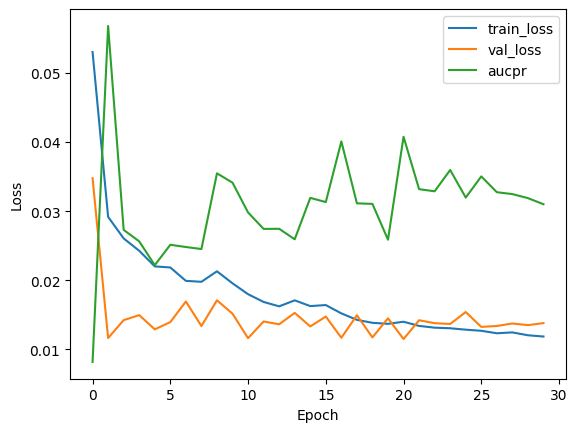

In [33]:
import matplotlib.pyplot as plt
#log = pd.read_csv('model/0811_2042/training_log.csv')
plt.plot(log['train_loss'], label='train_loss')
plt.plot(log['val_loss'], label='val_loss')
plt.plot(log['aucpr'], label='aucpr')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

### Model Evaluation

In [76]:
model.load_state_dict(torch.load(r'model\0814_0518\epoch_30.pth', weights_only=True))

<All keys matched successfully>

In [77]:
# 評估 train 分佈：不用 sampler、不shuffle
train_loader_eval = DataLoader(
    train_ds, batch_size=1024, shuffle=False, num_workers=8, pin_memory=True
)


In [78]:
train_trues, train_outputs, train_loss= test_loop(model, train_loader_eval, criterion=criterion)


Testing: 100%|██████████| 44/44 [00:09<00:00,  4.82it/s]


In [79]:
def plot_outputs_distribution(outputs, title):
    plt.hist(outputs, bins=50, range=(0, 1))
    plt.xlabel("Output Value")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.show()


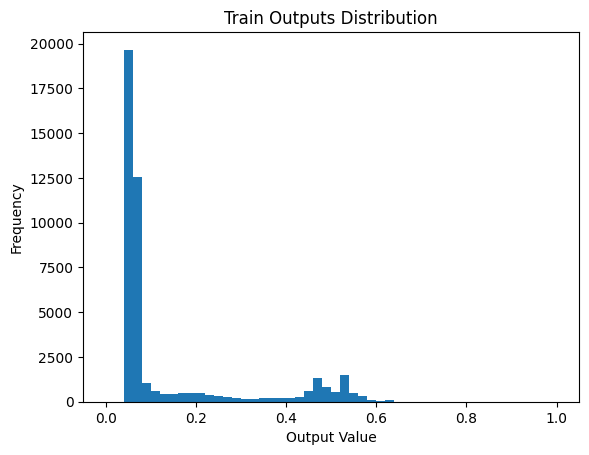

In [80]:
plot_outputs_distribution(train_outputs, "Train Outputs Distribution")

Performance on Training Set:
Train Loss: 0.00986887979855634
              precision    recall  f1-score   support

      Normal       1.00      0.89      0.94     42584
     Failure       0.28      0.99      0.44      1920

    accuracy                           0.89     44504
   macro avg       0.64      0.94      0.69     44504
weighted avg       0.97      0.89      0.92     44504

[[37721  4863]
 [   18  1902]]
ROC AUC: 0.9658


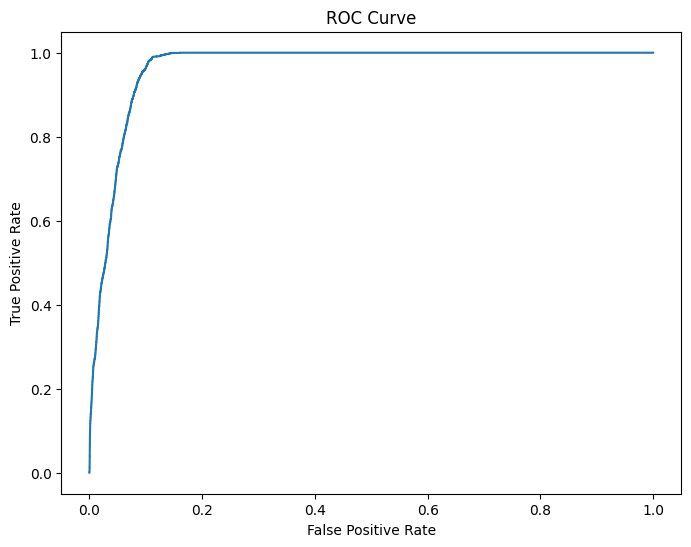

In [81]:
train_predictions = (train_outputs > 0.35).astype(int)

print("Performance on Training Set:")
print("Train Loss:", train_loss)

generate_report(train_trues, train_predictions, train_outputs)

In [82]:
val_trues, val_outputs, val_loss = test_loop(model, val_loader, device='cuda', criterion=criterion)

Testing: 100%|██████████| 12/12 [00:07<00:00,  1.63it/s]


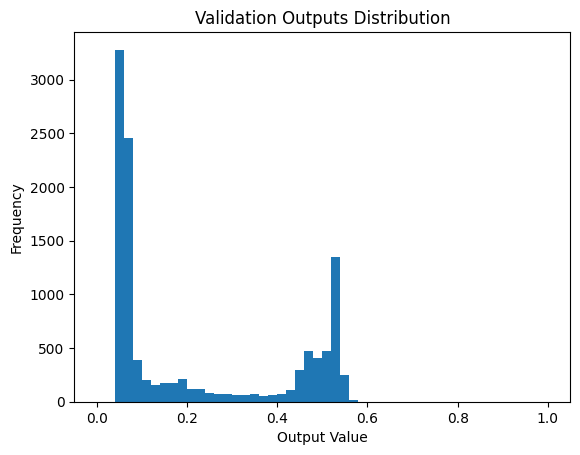

In [83]:
plot_outputs_distribution(val_outputs, "Validation Outputs Distribution")


In [84]:
from sklearn.metrics import precision_recall_curve
prec, rec, thresholds = precision_recall_curve(val_trues, val_outputs, pos_label=1)

target_recall = 0.6
idx = next(i for i,r in enumerate(rec) if r < target_recall) - 1
best_threshold = thresholds[idx]
print(f"Threshold for recall ≥ {target_recall}: {best_threshold:.4f}, Precision={prec[idx]:.3f}")


Threshold for recall ≥ 0.6: 0.5266, Precision=0.030


Performance on Validation Set:
              precision    recall  f1-score   support

      Normal       1.00      0.89      0.94     11210
     Failure       0.03      0.60      0.06        60

    accuracy                           0.89     11270
   macro avg       0.51      0.75      0.50     11270
weighted avg       0.99      0.89      0.94     11270

[[10027  1183]
 [   24    36]]
ROC AUC: 0.8993


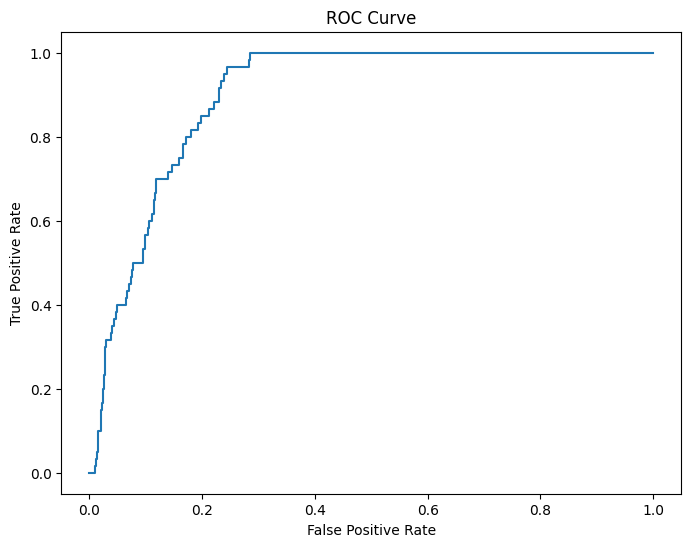

In [85]:
predictions = (val_outputs >= best_threshold).astype(int)
print("Performance on Validation Set:")
generate_report(val_trues, predictions, val_outputs)

In [86]:
test_trues, test_outputs, test_loss = test_loop(model, test_loader, device='cuda', criterion=criterion)

Testing: 100%|██████████| 11/11 [00:07<00:00,  1.52it/s]


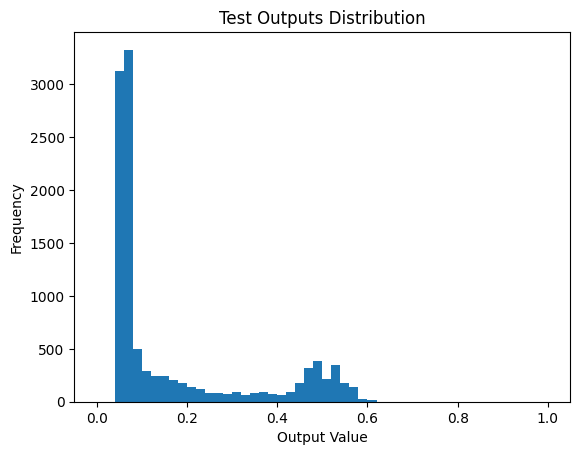

In [87]:
plot_outputs_distribution(test_outputs, "Test Outputs Distribution")

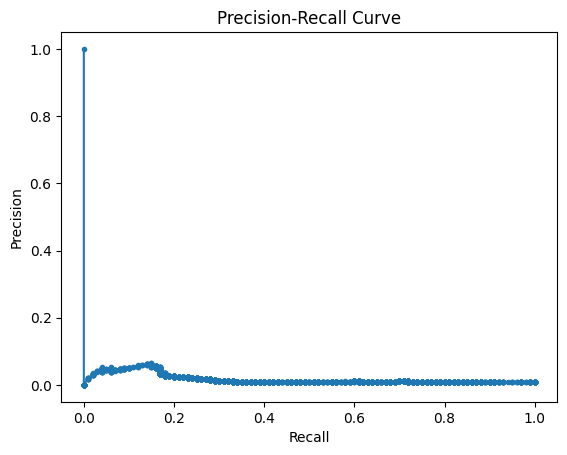

In [88]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(test_trues, test_outputs)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

Performance on Test Set:
              precision    recall  f1-score   support

      Normal       0.99      0.80      0.89     10879
     Failure       0.01      0.29      0.03       100

    accuracy                           0.80     10979
   macro avg       0.50      0.55      0.46     10979
weighted avg       0.98      0.80      0.88     10979

[[8734 2145]
 [  71   29]]
ROC AUC: 0.5291


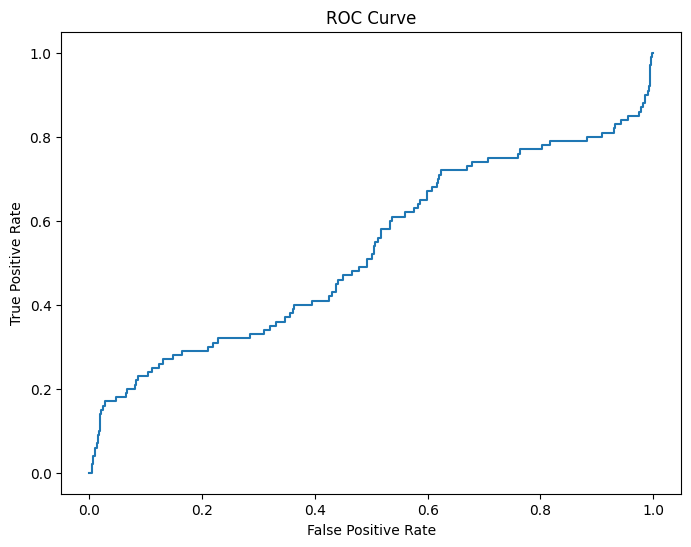

In [ ]:
predictions = (test_outputs >= best_threshold).astype(int)
print("Performance on Test Set:")
generate_report(test_trues, predictions, test_outputs)